# Predicting Hazardous NEOs (Nearest Earth Objects)

## Project Description:

- In this project, we will work with a real-world dataset that tracks Nearest Earth Objects (NEOs) observed by NASA from 1910 to 2024. The dataset contains 338,199 records, each representing an object in space that has been monitored for its proximity to Earth. Some of these objects are classified by NASA as "is_hazardous," indicating that they pose a potential danger to our planet.

### Task:
- Train a machine learning model that can accurately predict whether a NEO is hazardous or not. 

### 1. Data Importing and Cleaning:

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc

In [2]:
df = pd.read_csv('nearest-earth-objects(1910-2024).csv')

In [3]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
# missing values
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

### Observations:
- There are 28 missing values in these Columns: `absolute_magnitude`, `estimated_diameter_min`, and `estimated_diameter_max`.
- The number of missing values is small relative to the total dataset.

#### Handling Missing Values:

In [7]:
# check the percentage of missing values in columns with NaNs
missing_values = df.isnull().sum() / len(df) * 100
missing_values

neo_id                    0.000000
name                      0.000000
absolute_magnitude        0.008279
estimated_diameter_min    0.008279
estimated_diameter_max    0.008279
orbiting_body             0.000000
relative_velocity         0.000000
miss_distance             0.000000
is_hazardous              0.000000
dtype: float64

In [8]:
# Filling missing values with the median
df['absolute_magnitude'].fillna(df['absolute_magnitude'].median(), inplace=True)
df['estimated_diameter_min'].fillna(df['estimated_diameter_min'].median(), inplace=True)
df['estimated_diameter_max'].fillna(df['estimated_diameter_max'].median(), inplace=True)

### 2. Exploratory Data Analysis (EDA):

In [9]:
# Descriptive Statistics
df.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338199.000000,338199.000000,338199.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932514,0.157805,0.352863,51060.662908,4.153535e+07
std,2.287225e+07,2.911096,0.313873,0.701842,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [10]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0.5, 1.0, 'Count of Hazardous vs Non-Hazardous NEOs')

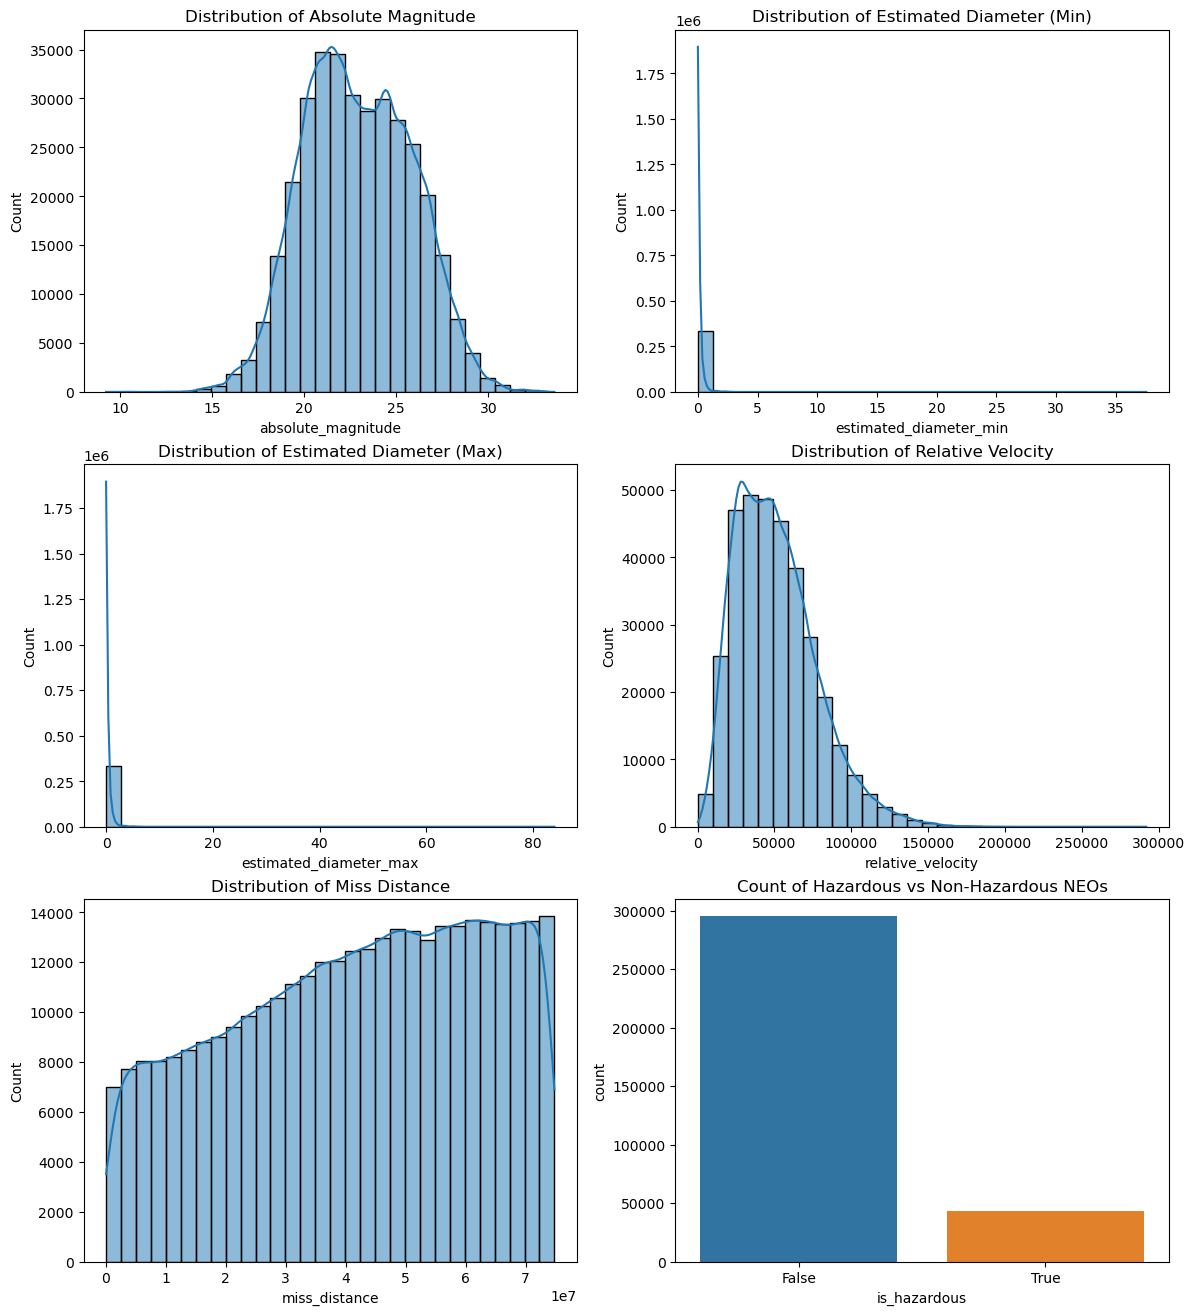

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

# Absolute magnitude distribution
sns.histplot(df['absolute_magnitude'], bins=30, kde=True, ax=axes[0,0])
axes[0, 0].set_title('Distribution of Absolute Magnitude')

# Estimated Diameter (Min) Distribution
sns.histplot(df['estimated_diameter_min'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Estimated Diameter (Min)')

# Estimated Diameter (Max) Distribution
sns.histplot(df['estimated_diameter_max'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Estimated Diameter (Max)')

# Relative Velocity Distribution
sns.histplot(df['relative_velocity'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Relative Velocity')

# Miss Distance Distribution
sns.histplot(df['miss_distance'], bins=30, kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Miss Distance')

# Hazardous NEO Count Plot
sns.countplot(x='is_hazardous', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Count of Hazardous vs Non-Hazardous NEOs')

#### Observations:
- Most NEOs have moderate brightness.
- The diameters (Min and Max) are highly skewed.
- NEOs typically travel at moderate speeds but a few outliers have extremely high velocities.
- Most NEOs pass Earth at safe distances.
- The vast majority of NEOs are non-hazardous, but a small portion is classified as hazardous.

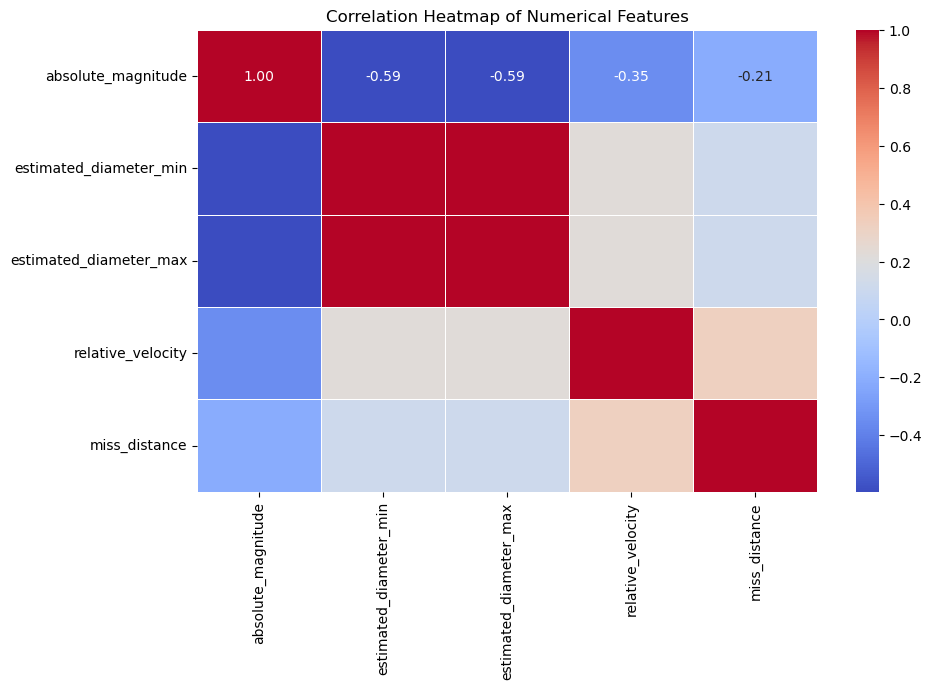

In [13]:
# calculate the correlation heatmap to analyze relationships between the numerical features.
correlation_matrix = df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max',
                           'relative_velocity', 'miss_distance']].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

#### Key Insights:
- There's a moderate inverse relationship between the object diameter and the magnitude, meaning brighter NEOs tend to be smaller.
- The relative velocity and miss distance of objects are weakly correlated with the other features, indicating that these features do not have a strong direct relationship with size or brightness.
- The perfect correlation between min and max diameter confirms that they essentially describe the object size.

### 3. Data Preprocessing:

#### Feature Selection:

In [14]:
# Dropping columns that they don't provide predictive value
df.drop(columns=['neo_id', 'name', 'orbiting_body'], inplace=True)

#### Encoding Categorical Variables:

In [15]:
# Applying label Encoder because the 'is_hazardous' is categorical
label_encoder = LabelEncoder()
df['is_hazardous'] = label_encoder.fit_transform(df['is_hazardous'])
df

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.140,0.394962,0.883161,71745.401048,5.814362e+07,0
1,18.500,0.530341,1.185878,109949.757148,5.580105e+07,1
2,21.450,0.136319,0.304818,24865.506798,6.720689e+07,0
3,20.630,0.198863,0.444672,78890.076805,3.039644e+07,0
4,22.700,0.076658,0.171412,56036.519484,6.311863e+07,0
...,...,...,...,...,...,...
338194,28.580,0.005112,0.011430,56646.985988,6.406548e+07,0
338195,28.690,0.004859,0.010865,21130.768947,2.948883e+07,0
338196,21.919,0.109839,0.245607,11832.041031,5.346078e+07,0
338197,23.887,0.044377,0.099229,56198.382733,5.184742e+06,0


#### Scaling Numerical Features:

In [16]:
# Separating the features and the target variable
X = df.drop(columns=['is_hazardous'])
y = df['is_hazardous']

In [17]:
# Applying StandardScaler to numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# check the imbalance in the target class ('is_hazardous')
y.value_counts(normalize=True) * 100

is_hazardous
0    87.237691
1    12.762309
Name: proportion, dtype: float64

#### Handling Imablanced Classes:

In [19]:
# check the numbers of ('is_hazardous') for every value
counter = Counter(y)
print('Before', counter)

Before Counter({0: 295037, 1: 43162})


In [20]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

counter = Counter(y_resampled)
print('After', counter)

After Counter({0: 295037, 1: 295037})


### 4. Model Training and Evaluation:

In [21]:
# Split the resampled data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

#### 1. Logistic Regression Model:

In [22]:
# Logistic Regression Model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [23]:
# Make predictions 
y_pred_logistic = logistic_model.predict(X_test)

In [24]:
# Calculate metrics 
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}\n")


evaluate_model(y_test, y_pred_logistic, "Logistic Regression")

--- Logistic Regression Performance ---
Accuracy: 0.7952
Precision: 0.7525
Recall: 0.8793
F1-Score: 0.8110
AUC-ROC: 0.7953



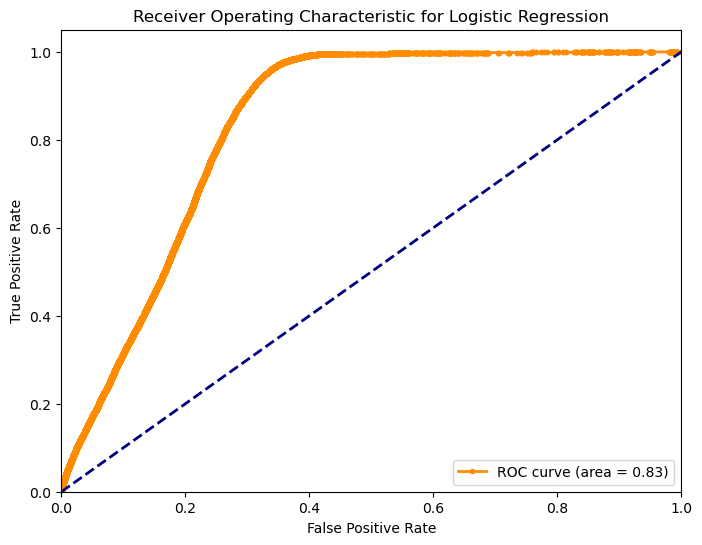

In [26]:
# Plot the ROC curves for each model
def plot_roc(y_test, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, marker= '.', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Calculate the predicted probabilities
y_probs_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Plot ROC
plot_roc(y_test, y_probs_logistic, "Logistic Regression")

#### 2. Decision Tree Model

In [27]:
# Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
# Make predictions 
y_pred_tree = tree_model.predict(X_test)

In [29]:
# Calculate metrics 
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}\n")


evaluate_model(y_test, y_pred_tree, "Decision Tree")

--- Decision Tree Performance ---
Accuracy: 0.9169
Precision: 0.9118
Recall: 0.9230
F1-Score: 0.9173
AUC-ROC: 0.9169



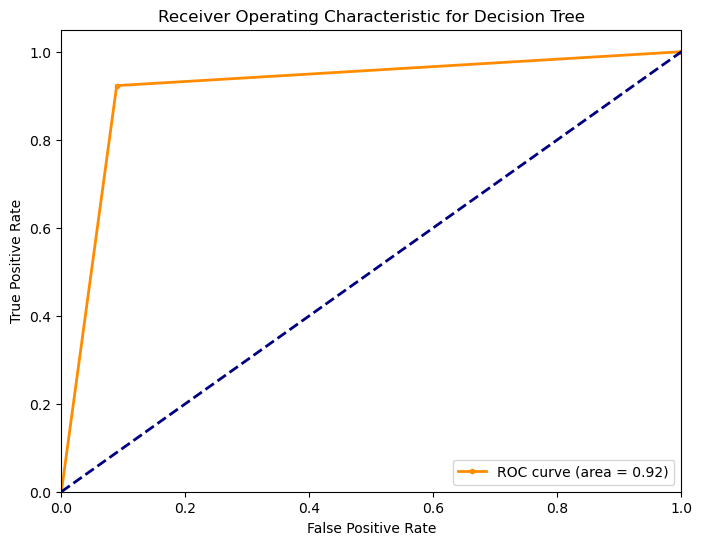

In [30]:
# Plot the ROC curves for each model
def plot_roc(y_test, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, marker= '.', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Calculate the predicted probabilities
y_probs_tree = tree_model.predict_proba(X_test)[:, 1]

# Plot ROC
plot_roc(y_test, y_probs_tree, "Decision Tree")

#### 3. Random Forest Model

In [31]:
# Random Forest Model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [32]:
# Make predictions 
y_pred_rf = rf_model.predict(X_test)

In [33]:
# Calculate metrics 
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}\n")

evaluate_model(y_test, y_pred_rf, "Random Forest")

--- Random Forest Performance ---
Accuracy: 0.9492
Precision: 0.9379
Recall: 0.9620
F1-Score: 0.9498
AUC-ROC: 0.9492



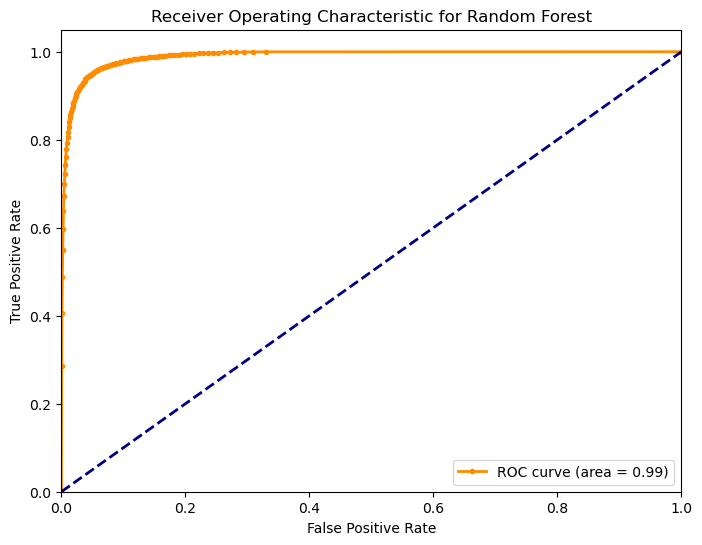

In [34]:
# Plot the ROC curves for each model
def plot_roc(y_test, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, marker= '.', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Calculate the predicted probabilities
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Plot ROC
plot_roc(y_test, y_probs_rf, "Random Forest")

##### The best model performance is random forest with:
- Accuracy-Score: 94.92%
- Precision: 93.79%
- Recall: 96.20%
- F1-Score: 94.98%
- AUC-ROC: 0.9492

### Author
#### Nahla Mohamed Armash